In [ ]:
%load_ext autoreload
%autoreload 2
# default_exp indexers.faceclustering.indexer

In [ ]:
# export
from integrators.indexers.facerecognition.facerecognition_indexer import *
from integrators.indexers.faceclustering.models import *
from integrators.indexers.faceclustering.utils import *
from integrators.data.basic import *
from integrators.data.schema import *
from integrators.imports import *
from integrators.indexers.facerecognition.photo import *
from integrators.indexers.indexer import *
from integrators.pod.client import PodClient, DEFAULT_POD_ADDRESS

In [ ]:
# export
from fastprogress.fastprogress import progress_bar
from mmcv.runner import load_checkpoint
from collections import Counter
import cv2
import ipdb
import torch

# Face Clustering 

In [ ]:
# export

class FaceClusteringIndexer(IndexerBase):
    model_fname = "pretrained_gcn_v_ms1m.pth"
    model_path = MODEL_DIR / model_fname
    model_s3_url = f"{MEMRI_S3}/{model_fname}"
    
    def __init__(self, *args, **kwargs):
        self.rec_model = FaceRecognitionIndexer()
        self.model = GCN_V(feature_dim=256, nhid=512, nclass=1, dropout=0.0)
        download_file(self.model_s3_url, self.model_path)
        load_checkpoint(self.model, str(self.model_path), map_location="cpu", strict=True);
        self.model.eval()
        super().__init__(*args, **kwargs)
        
    def get_data(self, client, indexer_run):
        photos = [d.expand(client) for d in get_indexer_run_data(client, indexer_run)]
        for p in photos: client._load_photo_data(p, size=640)
        photos = [p for p in photos if p.data is not None]
        return IndexerData(photos=photos)
        
    def get_clusters(self, pred_confs, dataset):
        pred_dist2peak, pred_peaks = confidence_to_peaks(dataset.dists, dataset.nbrs,pred_confs, max_conn=1)
        pred_labels = peaks_to_labels(pred_peaks, pred_dist2peak, tau=0.4, inst_num=dataset.inst_num)
        # original tau: 0.65
        return pred_labels

    def get_predictions(self, features):
        dataset = GCNVDataset(features)
        features = torch.FloatTensor(dataset.features)
        adj = sparse_mx_to_torch_sparse_tensor(dataset.adj)
        pred_confs, _ = self.model((features, adj), output_feat=True)
        clusters = self.get_clusters(pred_confs.detach().numpy(), dataset)
        return clusters
    
    def create_cluster_items(self, crop_photos, pred_labels, min_cluster_size=2):
        c2p = {c: Person(firstName="unknown person") for c in set(pred_labels)
               if list(pred_labels).count(c) >= min_cluster_size }
        
        for photo, clust in zip(crop_photos, pred_labels):
            if clust in c2p:
                person = c2p[clust]
                person.add_edge("occurence", photo)
        people = list(c2p.values())
        return people
    
    def get_crops(self, photos):
        return self.rec_model.get_crops(photos)
    
    def index(self, data, *args, **kwargs):
        photos = data.photos
        print(f"Indexing {len(photos)} photos")
        crop_photos = self.get_crops(photos)
        files = [c.file[0] for c in crop_photos]
        for c in progress_bar(crop_photos): c.embedding = self.rec_model.get_embedding(c)
        features = np.stack([x.embedding[256:] for x in crop_photos])
        pred_labels = self.get_predictions(features)
        people = self.create_cluster_items(crop_photos, pred_labels)
        return crop_photos + people + files

In [ ]:
test_registration(FaceClusteringIndexer)

# Cluster

## Create test dataset

In [ ]:
data_dir = PYI_TESTDATA / "photos" / "faceclustering"
photos   = [IPhoto.from_path(path=x, size=640) for x in data_dir.ls() if str(x).endswith("jpg")]
data = IndexerData(photos=photos)

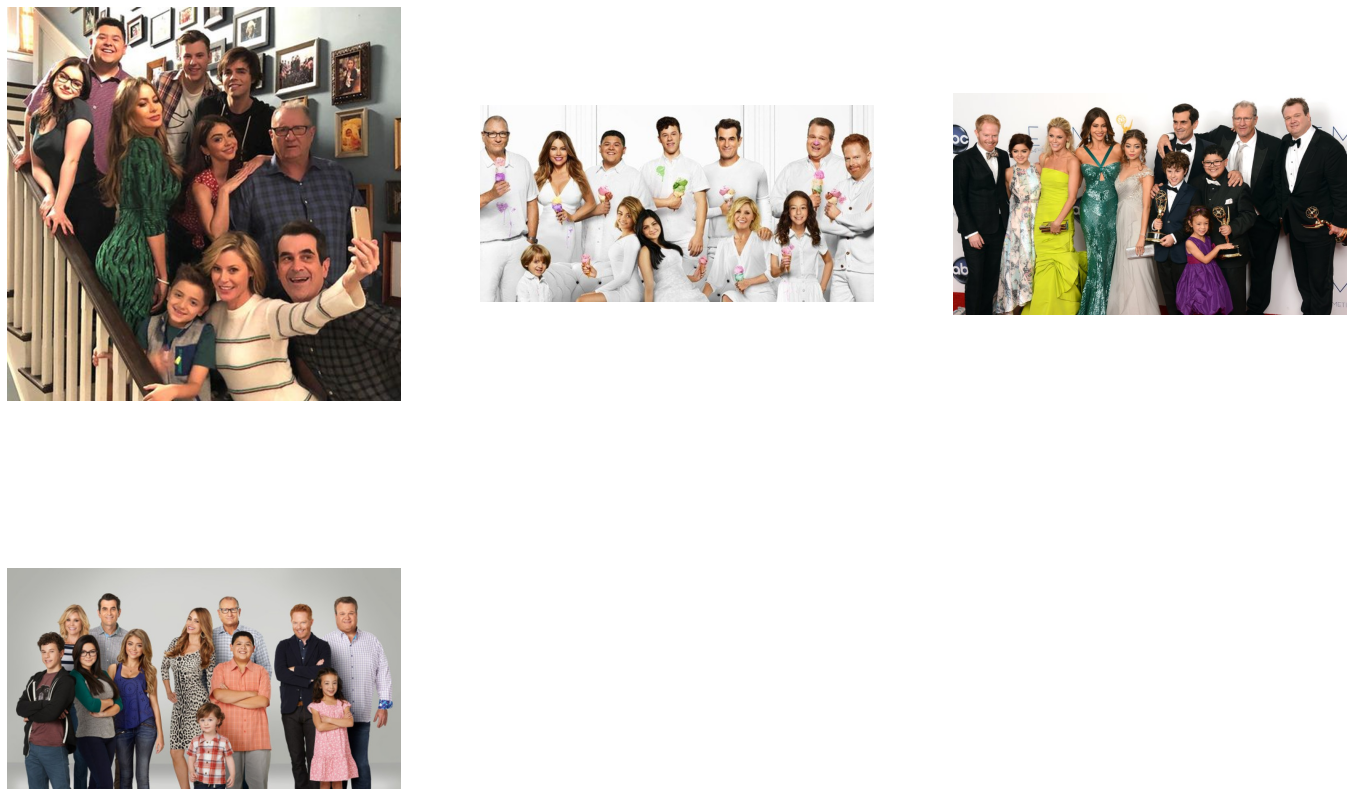

In [ ]:
show_images(photos)

## Run the model

In [ ]:
cluster_indexer = FaceClusteringIndexer()

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


In [ ]:
items = cluster_indexer.index(data)

Indexing 4 photos


## Show the result

In [ ]:
people = [x for x in items if isinstance(x, Person) and len(x.occurence) >=1]
print(len(people))

12


Cluster


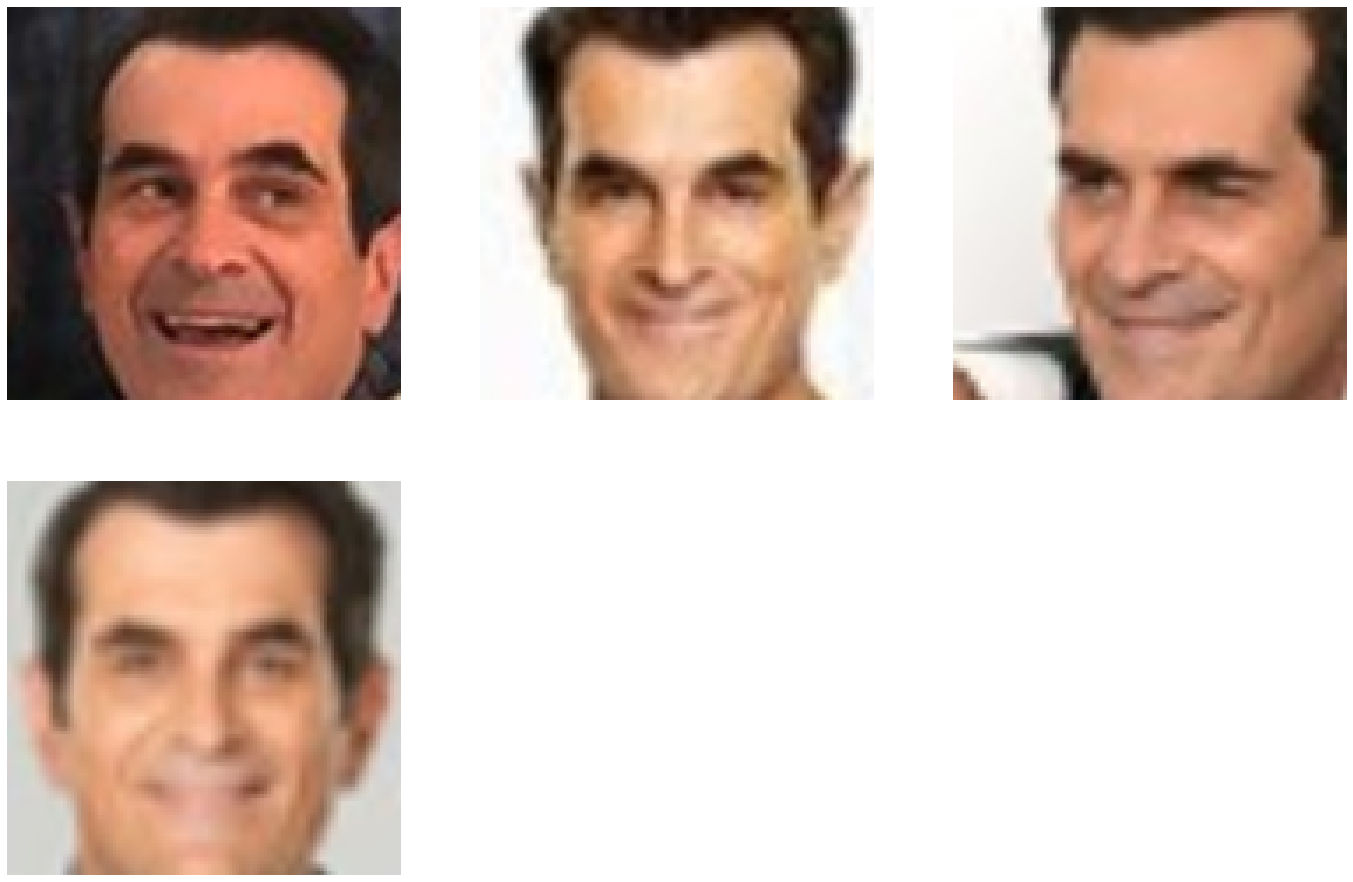

Cluster


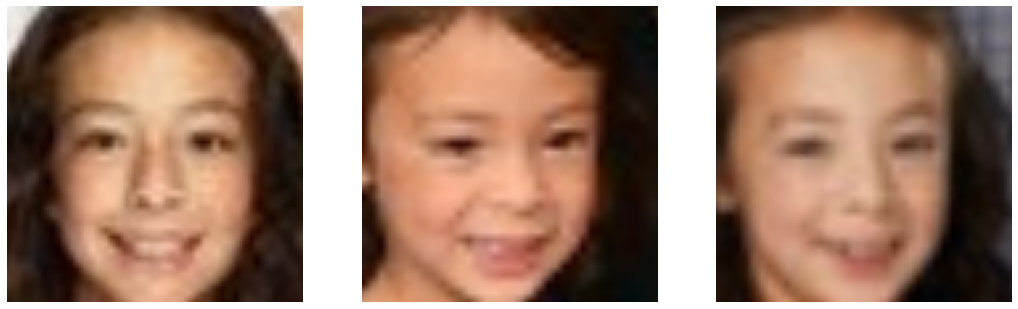

In [ ]:
for p in people[-2:]:
    print("Cluster")
    show_images([p.data for p in p.occurence])

## Run from env

In [ ]:
database_key = "B53A8B31D91A46309ECCB044AF1947F6AF4E81CACA3A4F31ABACC2D8495975F0"

In [ ]:
owner_key = "15826F7F53D3BA753DAC0F360E974DF4F02F57430A39A2882EB1698C82B5345E"

In [ ]:
run_id = 1000001520

In [ ]:
client = PodClient(database_key=database_key, owner_key=owner_key)

In [ ]:
client.search_by_fields({"_type": "Photo"})[0].file[0]

File (#1000001117)

In [ ]:
get_indexer_run_data??

In [ ]:
run_integrator(pod_full_address=DEFAULT_POD_ADDRESS,
               integrator_run_uid=run_id,
               database_key=database_key,
               owner_key=owner_key)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000087) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000089) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000091) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000093) attached file

<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000189) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000191) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000193) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000195) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000197) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file 

<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000957) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000959) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000961) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000965) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file or directory (os error 2)'
Could not load data of IPhoto (#1000000967) attached file item does not have data in pod
<Response [500]> b'Failed to read data from target file, No such file 

ValueError: need at least one array to stack

In [ ]:
%debug

> /opt/anaconda3/envs/memri/lib/python3.7/site-packages/numpy/core/shape_base.py(423)stack()
    421     arrays = [asanyarray(arr) for arr in arrays]
    422     if not arrays:
--> 423         raise ValueError('need at least one array to stack')
    424 
    425     shapes = {arr.shape for arr in arrays}

ipdb> u
> <__array_function__ internals>(6)stack()

ipdb> u
> /Users/koen/workspace/pyintegrators/integrators/indexers/faceclustering/indexer.py(79)index()
     77         files = [c.file[0] for c in crop_photos]
     78         for c in progress_bar(crop_photos): c.embedding = self.rec_model.get_embedding(c)
---> 79         features = np.stack([x.embedding[256:] for x in crop_photos])
     80         pred_labels = self.get_predictions(features)
     81         people = self.create_cluster_items(crop_photos, pred_labels)

ipdb> u
> /Users/koen/workspace/pyintegrators/integrators/indexers/indexer.py(48)run()
     46     def run(self, indexer_run, client):
     47         data = self.ge

In [ ]:
client = PodClient()

In [ ]:
# photos = [IPhoto.from_path(path=x, size=640) for x in data_dir.ls() if str(x).endswith("jpg")]
# indexer = Indexer.from_data(indexerClass="FaceClusteringIndexer", name="FaceClustering")
# indexer_run = IndexerRun.from_data(progress=0, targetDataType="Photo")

# for x in [indexer, indexer_run] + photos : client.create(x)
# assert client.create_edge(Edge(indexer_run, indexer, "indexer"))

In [ ]:
run_integrator(pod_full_address=DEFAULT_POD_ADDRESS,
               integrator_run_uid=indexer_run.uid,
               database_key=client.database_key,
               owner_key=client.owner_key)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto (#None)
creating IPhoto 

In [ ]:
client.delete_all()

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


# Export -

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted basic.ipynb.
Converted importers.EmailImporter.ipynb.
Converted importers.Importer.ipynb.
Converted importers.util.ipynb.
Converted index.ipynb.
Converted indexers.FaceClusteringIndexer.Models.ipynb.
Converted indexers.FaceClusteringIndexer.Utils.ipynb.
Converted indexers.FaceClusteringIndexer.indexer.ipynb.
Converted indexers.FaceRecognitionIndexer.ipynb.
Converted indexers.FacerecognitionIndexer.Photo.ipynb.
Converted indexers.GeoIndexer.ipynb.
Converted indexers.NoteListIndexer.NoteList.ipynb.
Converted indexers.NoteListIndexer.Parser.ipynb.
Converted indexers.NoteListIndexer.ipynb.
Converted indexers.NoteListIndexer.util.ipynb.
Converted indexers.indexer.ipynb.
Converted itembase.ipynb.
Converted pod.client.ipynb.
